# Simple Bitcoin predictive Model

## Imports & API

In [79]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import requests 
import matplotlib as plt
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

response = requests.get("https://api.coindesk.com/v1/bpi/historical/close.json?start=2010-09-01&end=2018-03-21")

In [13]:
response.status_code

200

In [14]:
bpi = response.json()['bpi']

In [15]:
bit = pd.DataFrame.from_dict(bpi,orient='index')

In [16]:
bit = bit.set_index(pd.to_datetime(bit.index))

In [17]:
bit.columns = ['bpi']
bit['diff'] = bit['bpi'].diff()

In [18]:
reddit = pd.read_csv('./Reddit_Crypto.csv')

FileNotFoundError: File b'./Reddit_Crypto.csv' does not exist

In [19]:
reddit.title = reddit.title.str.lower()
reddit = reddit.drop('Unnamed: 0',axis=1)
reddit.date = pd.to_datetime(reddit['date'])
reddit['hour'] = reddit.date.dt.hour

NameError: name 'reddit' is not defined

In [20]:
reddit = reddit.set_index(reddit.date)

NameError: name 'reddit' is not defined

In [21]:
reddit

NameError: name 'reddit' is not defined

## Preliminary EDA

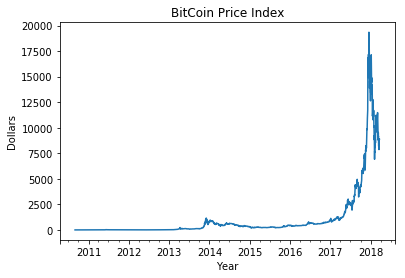

In [22]:
#
bit.bpi.plot()
plt.title('BitCoin Price Index')
plt.ylabel('Dollars')
plt.xlabel('Year');

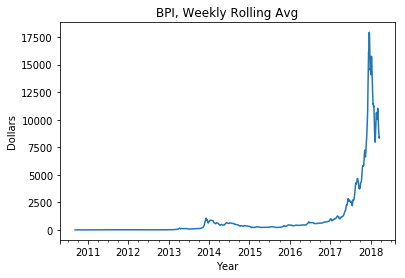

In [23]:
#weekly rolling avg by week
bit.bpi.rolling(window=7, center=False).mean().plot()
plt.title('BPI, Weekly Rolling Avg')
plt.ylabel('Dollars')
plt.xlabel('Year');

### Autocorrelation & Partial Autocorrelation

because of how correlated every day's bitcoin value is dependant on the day before,
we look at its autocorrelation.
    - (correlation, to itself)

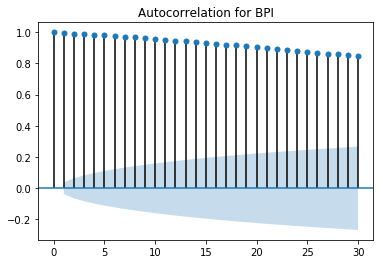

In [24]:
plot_acf(bit.bpi, lags=30)
plt.title('Autocorrelation for BPI');

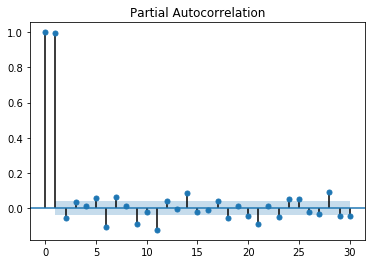

In [25]:
plot_pacf(bit.bpi, lags=30);

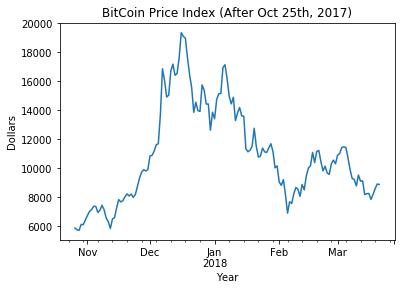

In [26]:
#
bit[bit.index>'2017-10-25']['bpi'].plot()
plt.title('BitCoin Price Index (After Oct 25th, 2017)')
plt.ylabel('Dollars')
plt.xlabel('Year');

## Trend, Seasonality & Trend

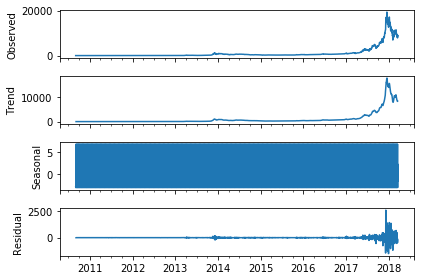

In [29]:
result = seasonal_decompose(bit.bpi)
result.plot();

Well that looks like a mess, likely due to the amount of time when bitcoin was worthless

Lets look at it when bitcoin became a bit more relivant

In [30]:
relivant  = bit[bit.index>'2016-10-27']['bpi']

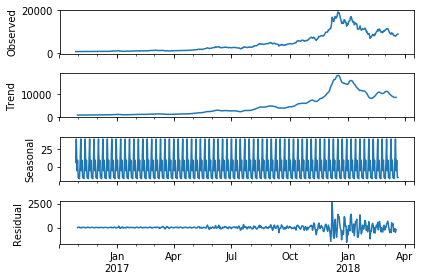

In [31]:
result = seasonal_decompose(relivant)
result.plot();

That looks better, but still a lot of dead time

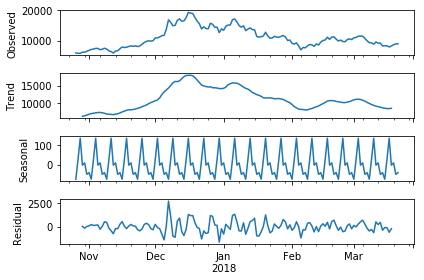

In [32]:
more_rel = bit[bit.index>'2017-10-25']['bpi']
seasonal_decompose(more_rel).plot();

Much better, well now we can see some clearer trends.

This shows us:
    - a clearer trend over time peaking in late Dec
    - Bitcoin does not seem to be heavily affected by seasonality, only +/- 100
    - Residuals seem to make up the majority of variablity, which makes sense consider how  bitcoins have stronger social driving facters rather than seasonal/global

## LSTM RNN

I am sceptical that this NN this will provide much insight, considering our seasonality analysis showed how heavily residuals affect the overall value.

Our target is to predict the value of bitcoin a week from the end of a training set

As to avoid having more weight given to the time during which Bitcoin was worthless.
- I am using the 'more_relivant' time set which is after Oct.25.2017
- The reasoning here is "bitcoin's very low value could be highly due to its nature being unknown to the majority of the public, after that arbitrary point, it became more well known and thus more active"

In [214]:
train = more_rel[more_rel.index<'2018-03-01']
test = more_rel[more_rel.index>='2018-03-01']

In [215]:
#NN need values between 0-1
mm = MinMaxScaler()

#preprocessing
#mm scaler needs atleast a 2D array
train = np.reshape(train.values, (len(train), 1))
train = mm.fit_transform(train)

#here we are predicting Q days ahead
Q = 7
X_train = train[0:len(train)-Q]
y_train = train[Q:len(train)]

#RNN again, needs reshaping
#the shaping choices were picked for if I want to use a multi-dim training
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [221]:
def model(X_train, y_train, dropout= 0.1, batch_size = 5, lstm_units = 7, activation = 'linear'):
    # Initialising the RNN
    regressor = Sequential()

    # Adding the input layer and the LSTM layer
    regressor.add(LSTM(units = lstm_units, activation = activation, input_shape = (None, 1)))
    regressor.add(Dropout(dropout))
    
    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mae')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = batch_size, epochs = 100)
    return(regressor)

In [222]:
regressor = model(X_train,y_train)

Epoch 1/100
60/60 [==============================] - 4s 71ms/step - loss: 0.4979
Epoch 2/100
60/60 [==============================] - 0s 2ms/step - loss: 0.4698
Epoch 3/100
60/60 [==============================] - 0s 2ms/step - loss: 0.4409
Epoch 4/100
60/60 [==============================] - 0s 1ms/step - loss: 0.4124
Epoch 5/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3936
Epoch 6/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3756
Epoch 7/100
60/60 [==============================] - 0s 1ms/step - loss: 0.3577
Epoch 8/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3492
Epoch 9/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3374
Epoch 10/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3261
Epoch 11/100
60/60 [==============================] - 0s 1ms/step - loss: 0.3172
Epoch 12/100
60/60 [==============================] - 0s 2ms/step - loss: 0.3081
Epoch 13/100
60/60 [================

In [223]:
# Making the predictions
test_set = test.values

#reshape for scaling
val = np.reshape(test_set, (len(test_set), 1))
val = mm.transform(val)

#reshaped for NN
val = np.reshape(val, (len(val), 1, 1))
predicted_BTC_price = regressor.predict(val)
predicted_BTC_price = mm.inverse_transform(predicted_BTC_price)[:,0]

In [224]:
pred = pd.DataFrame({'True':test_set,'Pred':predicted_BTC_price},index=test.index)

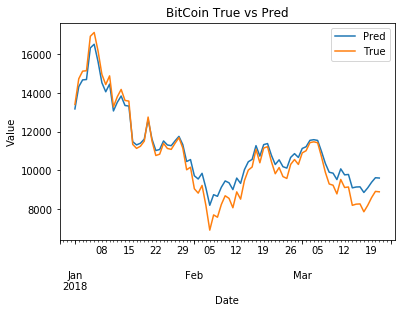

In [225]:
pred.plot()
plt.title('BitCoin True vs Pred')
plt.ylabel('Value')
plt.xlabel('Date');

## ARIMA

Lets go back to more traditional forcasting models

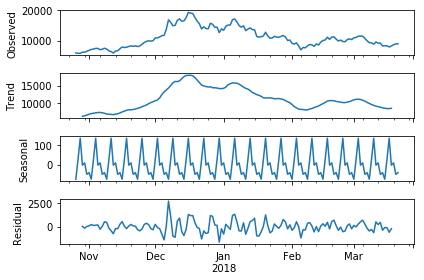

In [235]:
season = seasonal_decompose(more_rel)
season.plot();

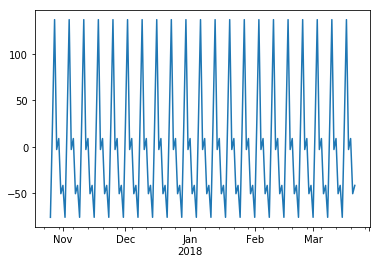

In [236]:
#It looks like the variation may align with weeks
#it would be interesting to see what days have more activity, and see how activity relates to value
season.seasonal.plot();

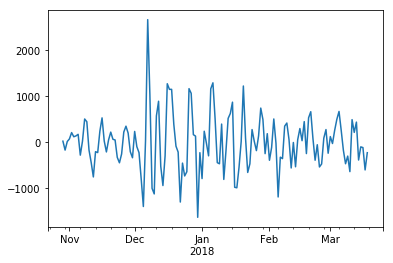

In [237]:
#Again huge imact
#It would be interesting to scrape the news/twitter/reddit 
#for what may have been a predictor for any underlying trends in these residuals
season.resid.plot();

In [238]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )

### Seasonal Difference

In [252]:
#so reminder this is our data
bit.head()

,bpi,diff
2010-09-01,0.0629,NaN
2010-09-02,0.0634,0.0005
2010-09-03,0.0609,-0.0025
2010-09-04,0.0624,0.0015
2010-09-05,0.0616,-0.0008


In [253]:
#remember we are paying attention to when bitcoin was relivant, 'more_rel' is a numpy array
rel = bit[bit.index>'2017-10-25']

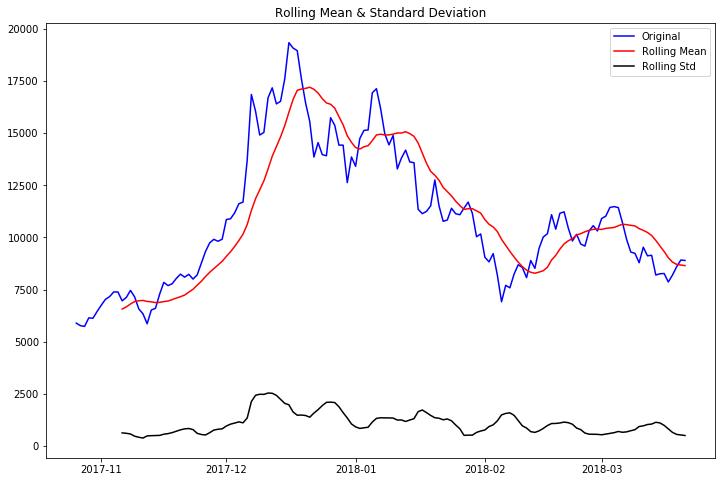

Results of Dickey-Fuller Test:
Test Statistic   -1.740038
p-value           0.410611
dtype: float64


In [254]:
#let us check and see how stationary the data is, so we can gather what we can from it
test_stationarity(rel['bpi'])

Unsurprising, the values alone are NOT stationary, because it hasn't be adjusted for

Let us look at the differences by the day

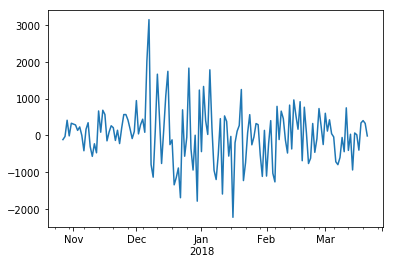

In [255]:
#note, I am not using rel['diff'] because ['diff'] is the difference by one day, 
#and it can be clearer to stack multiple .diffs to be clearer 
#to say on which periods are being accounted for

rel['bpi'].diff(1).plot();

Let us check how stationary the data is

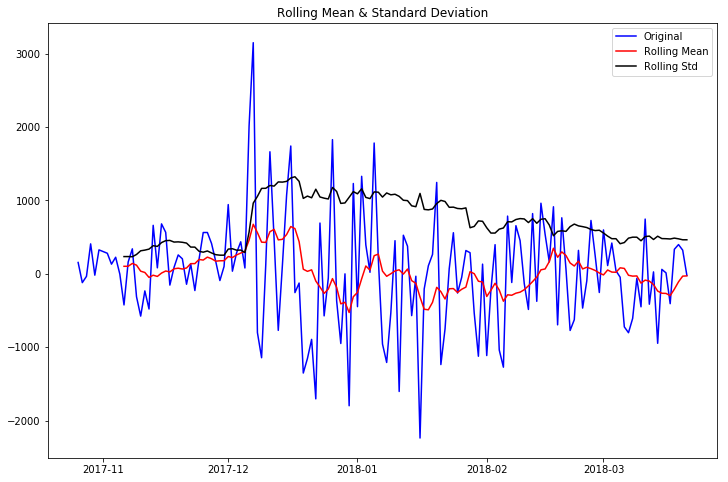

Results of Dickey-Fuller Test:
Test Statistic   -1.092902e+01
p-value           9.931712e-20
dtype: float64


In [258]:
test_stationarity(rel['diff'])

Well those map VERY heavily, so yeah it appears that the differences are stationary

Does finding the difference by the season AS well as the day improve things?

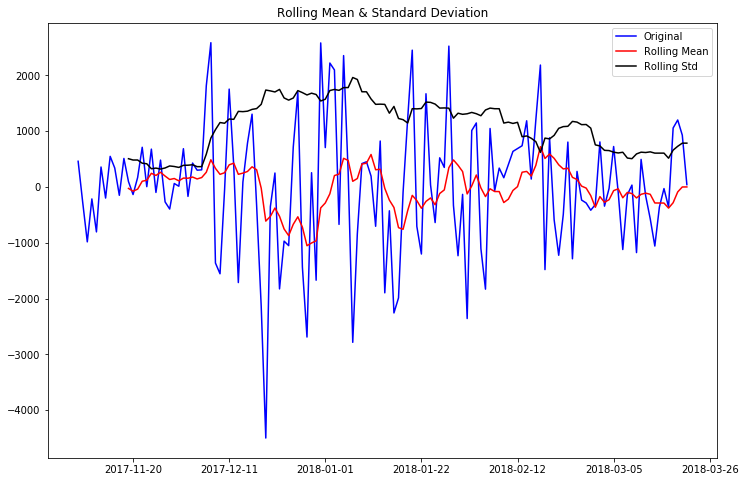

Results of Dickey-Fuller Test:
Test Statistic   -4.809367
p-value           0.000052
dtype: float64


In [244]:
#.diff(1) = diff by the day
#.diff(12) = diff by the months in year

test_stationarity(rel['bpi'].diff(1).diff(12).dropna())

In [245]:
rr = rel['bpi'].diff(1).diff(12).dropna()

In [247]:
from statsmodels.tsa.arima_model import ARIMA, ARMA

train_2 =  rr.head(80)
test_2 = rr.tail(21)

model = ARMA(train_2, (2,1)).fit()
model.summary()

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    bpi   No. Observations:                   80
Model:                     ARMA(2, 1)   Log Likelihood                -683.661
Method:                       css-mle   S.D. of innovations           1244.215
Date:                Tue, 27 Mar 2018   AIC                           1377.322
Time:                        12:38:43   BIC                           1389.232
Sample:                    11-08-2017   HQIC                          1382.097
                         - 01-26-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -44.2616    147.144     -0.301      0.764    -332.658     244.135
ar.L1.bpi      0.3294      0.634      0.520      0.605      -0.913       1.571
ar.L2.bpi     -0.1769      0.156     -1.134      0.260      -0.482       0.129
ma.L1.bpi     -0.1053      0.643     -0.164      0.870      -1.365       1.155
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9311           -2.1879j            2.3778           -0.1860
AR.2            0.9311           +2.1879j            2.3778            0.1860
MA.1            9.5008           +0.0000j            9.5008            0.0000
-----------------------------------------------------------------------------
"""

In [250]:
#based on indices of training data
start = len(train) - 1
end = start + len(test) - 1 #past end of training data

predictions_oos = model.predict(start,end)
truth = test.bpi

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


AttributeError: 'Series' object has no attribute 'bpi'

In [260]:
rel.head()

,bpi,diff
2017-10-26,5888.1450,154.2412
2017-10-27,5767.6800,-120.4650
2017-10-28,5732.8250,-34.8550
2017-10-29,6140.5313,407.7063
2017-10-30,6121.8000,-18.7313


In [263]:
by_weekday

Mon      229091.9941
Tues     228578.7714
Wed      229041.4141
Thurs    225637.9243
Fri      227920.9004
Sat      230462.4043
Sun      228344.7632
Name: bpi, dtype: float64

In [277]:
import seaborn as sns

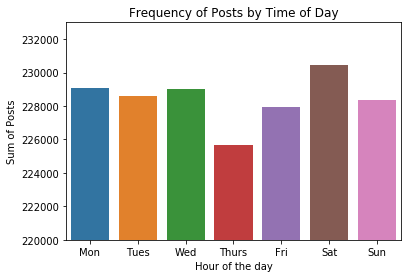

In [290]:
ax = sns.barplot(x=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], 
            y=rel.bpi.groupby(rel.index.dayofweek).sum())
ax.set_title('Frequency of Posts by Time of Day')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Sum of Posts');
plt.ylim(220000, 233000);